In this notebook, we will perform image retrieval with neural codes. We are applying the approach proposed in [1]. In particular, we train and evaluate a ConvNet on an image dataset. Then, we compute the outputs of intermediate layers for a new image dataset, which has not been used during training. These values serve as a representation, so-called *neural codes* for the new images. Then, we use the neural codes for image retrieval, by comparing the Euclidean distances between the codes of a query images and the remaining images. Finally, we evaluate the results both qualitatively and in terms of *mean average precision*.


[1] Artem Babenko, Anton Slesarev, Alexandr Chigorin, Victor Lempitsky, "Neural Codes for Image Retrieval"*, ECCV, 2014. https://arxiv.org/abs/1404.1777.

# Image Retrieval with Neural Codes


In [ ]:
%matplotlib inline

import os
import multiprocessing
import shutil
from google.colab import drive

import numpy as np
import pickle

import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Input, Dense, Conv2D, MaxPooling2D, ReLU, Dropout, Reshape, UpSampling2D, BatchNormalization
from tensorflow.keras import losses, optimizers
from tensorflow.keras.utils import plot_model

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time

num_train_classes = 190

Using TensorFlow backend.


# Download Tiny Imagenet
We will use the Tiny Imagenet dataset, which is a small subset of the original Imagenet dataset (http://www.image-net.org/). Tiny Imagenet has 200 classes, and contains 500 training examples for each class, i.e., 100,000 training examples in total. The images are of dimensions 64x64.

In [ ]:
# get tiny imagenet
if not os.path.isdir('tiny-imagenet-200'):
  if not os.path.isfile('tiny-imagenet-200.zip'):
    ! wget "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
  ! unzip -q tiny-imagenet-200.zip -d .

--2020-05-25 08:46:30--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.3MB/s    in 15s     

2020-05-25 08:46:45 (16.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

Unzipped.
Elapsed time: 28.076262712478638 seconds.


# Load Tiny Imagenet
We are going to use the official training set of Tiny Imagenet for our purposes, and ignore the official validation and test sets. 
We will use 190 classes (95,000 images) of the official training set to make new training, validation and test sets, containing 76,000, 9,500, and 9,500 images, respectively. The remaining 10 classes (5,000 images) will never have been seen during training, and will constitute an *out-of-domain* (ood) set.
The ood set will be used for image retrieval.
Thus, we'll have:

*   Train data: 76,000 images, 64x64x3 pixels, classes 0-189
*   Validation data: 9,500 images, 64x64x3 pixels, classes 0-189
*   Test data: 9,500 images, 64x64x3 pixels, classes 0-189
*   Out-of-domain data: 5000 images, 64x64x3 pixels, **classes 190-199**


In [ ]:
def load_imagenet(num_train_classes):
  def load_class_images(class_string, label):
    """
    Loads all images in folder class_string.

    :param class_string: image folder (e.g. 'n01774750')
    :param label: label to be assigned to these images
    :return class_k_img: (num_files, width, height, 3) numpy array containing
                         images of folder class_string
    :return class_k_labels: numpy array containing labels
    """
    class_k_path = os.path.join('tiny-imagenet-200/train/', class_string, 'images')
    file_list = sorted(os.listdir(class_k_path))

    dtype = np.uint8

    class_k_img = np.zeros((len(file_list), 64, 64, 3), dtype=dtype)
    for l, f in enumerate(file_list):
      file_path = os.path.join('tiny-imagenet-200/train/', class_string, 'images', f)
      img = mpimg.imread(file_path)
      if len(img.shape) == 2:
        class_k_img[l, :, :, :] = np.expand_dims(img, -1).astype(dtype)
      else:
        class_k_img[l, :, :, :] = img.astype(dtype)

    class_k_labels = label * np.ones(len(file_list), dtype=dtype)

    return class_k_img, class_k_labels

  # get the word description for all imagenet 82115 classes
  all_class_dict = {}
  for k, line in enumerate(open('tiny-imagenet-200/words.txt', 'r')):
    n_id, description = line.split('\t')[:2]
    all_class_dict[n_id] = description

  # this will be the description for our 200 classes
  class_dict = {}

  # we enumerate the classes according to their folder names:
  ls_train = sorted(os.listdir('tiny-imagenet-200/train'))
  img = None
  labels = None
  ood_x = None
  ood_y = None

  # the first num_train_classes will make the training, validation, test sets
  for k in range(num_train_classes):
    # the word descritpion of the current class
    class_dict[k] = all_class_dict[ls_train[k]]
    # load images and labels for current class
    class_k_img, class_k_labels = load_class_images(ls_train[k], k)
    # concatenate all samples and labels
    if img is None:
      img = class_k_img
      labels = class_k_labels
    else:
      img = np.concatenate((img, class_k_img), axis=0)
      labels = np.concatenate((labels, class_k_labels))

  # the remaining classes are the out of domain (ood) set 
  for k in range(num_train_classes, 200):
    class_dict[k] = all_class_dict[ls_train[k]]
    class_k_img, class_k_labels = load_class_images(ls_train[k], k)
    if ood_x is None:
      ood_x = class_k_img
      ood_y = class_k_labels
    else:
      ood_x = np.concatenate((ood_x, class_k_img), axis=0)
      ood_y = np.concatenate((ood_y, class_k_labels))

  return img, labels, ood_x, ood_y, class_dict

print('Loading data...')
start_time = time.time()
train_x, train_y, ood_x, ood_y, class_dict = load_imagenet(num_train_classes)
print('Data loaded in {} seconds.'.format(time.time() - start_time))

def split_data(x, y, N):
  x_N = x[0:N, ...]
  y_N = y[0:N]
  x_rest = x[N:, ...]
  y_rest = y[N:, ...]
  return x_N, y_N, x_rest, y_rest

# fix random seed
np.random.seed(42)

# shuffle
N = train_x.shape[0]
rp = np.random.permutation(N)
train_x = train_x[rp, ...]
train_y = train_y[rp]

# train/validation split 80 - 10 - 10
N_val = int(round(N * 0.1))
N_test = int(round(N * 0.1))
val_x, val_y, train_x, train_y = split_data(train_x, train_y, N_val)
test_x, test_y, train_x, train_y = split_data(train_x, train_y, N_test)

# shuffle ood data
N_ood = ood_x.shape[0]
rp = np.random.permutation(N_ood)
ood_x = ood_x[rp, ...]
ood_y = ood_y[rp]

# convert all data into float32
train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.float32)
val_x = val_x.astype(np.float32)
val_y = val_y.astype(np.float32)
test_x = test_x.astype(np.float32)
test_y = test_y.astype(np.float32)
ood_x = ood_x.astype(np.float32)
ood_y = ood_y.astype(np.float32)

# normalize
train_x /= 255.
val_x /= 255.
test_x /= 255.
ood_x /= 255.

print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(ood_x.shape)

Loading data...
Data loaded in 49.93973779678345 seconds.
(76000, 64, 64, 3)
(9500, 64, 64, 3)
(9500, 64, 64, 3)
(5000, 64, 64, 3)


# Displaying some images

train 30860: comic book



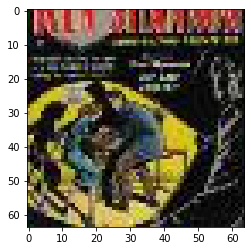

train 21145: teapot



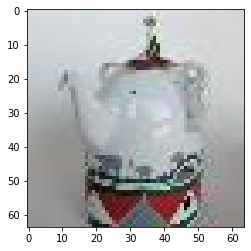

train 37042: bathtub, bathing tub, bath, tub



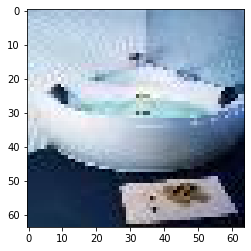

validation 3224: bullet train, bullet



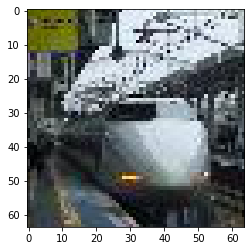

validation 7735: tarantula



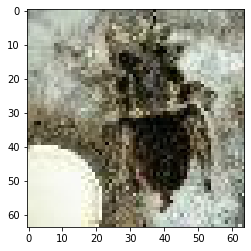

validation 7974: sea cucumber, holothurian



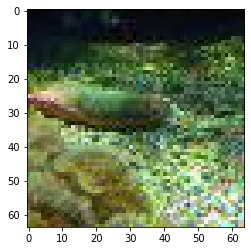

test 7810: Egyptian cat



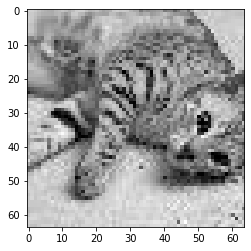

test 5597: snail



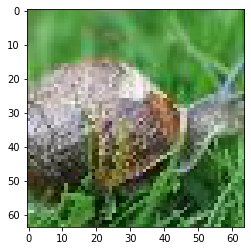

test 5693: plate



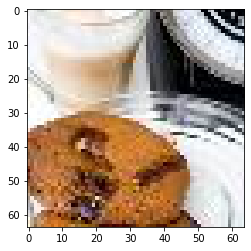

out of domain 737: coral reef



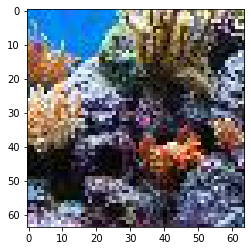

out of domain 4062: cliff, drop, drop-off



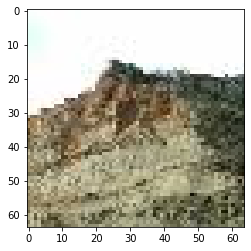

out of domain 1223: pizza, pizza pie



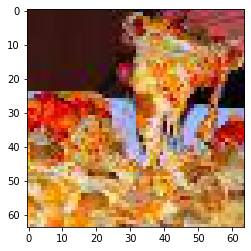

In [ ]:
def show_random_images(img, labels, K, qualifier):
  for k in range(K):
    idx = np.random.randint(0, img.shape[0])
    print("{} {}: {}".format(qualifier, idx, class_dict[labels[idx]]))
    plt.imshow(img[idx,:,:,:])
    plt.show()

show_random_images(train_x, train_y, 3, 'train')
show_random_images(val_x, val_y, 3, 'validation')
show_random_images(test_x, test_y, 3, 'test')
show_random_images(ood_x, ood_y, 3, 'out of domain')


# Make and Train Model

We implement a convolutional neural network similar to the one in [1].
We will simplify the architecture a bit since we are using Tiny Imagenet.



In [ ]:
def make_model():
  model = Sequential()

  model.add(Conv2D(96, kernel_size=(4, 4), input_shape=(64, 64, 3), strides=1, padding="same"))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding="same"))
  model.add(ReLU())
  
  model.add(Conv2D(192, kernel_size=(5, 5), strides=1, padding="same"))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding="same"))
  model.add(ReLU())

  model.add(Conv2D(288, kernel_size=(3, 3), strides=1, padding="same"))
  model.add(ReLU())

  model.add(Conv2D(288, kernel_size=(3, 3), strides=1, padding="same"))
  model.add(ReLU())

  model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding="same"))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=2, padding="same", name="max_pooling"))
  model.add(ReLU())

  model.add(Flatten())
  
  model.add(Dropout(0.5))
  model.add(Dense(2048, name="dense_1"))
  model.add(ReLU())

  model.add(Dropout(0.5))
  model.add(Dense(2048, name="dense_2"))
  model.add(ReLU())

  model.add(Dense(num_train_classes, activation="softmax"))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True), 
                loss=keras.losses.SparseCategoricalCrossentropy(), 
                metrics=["accuracy", keras.metrics.SparseTopKCategoricalAccuracy(k=5)])

  return model

def make_model_and_train():
  if not os.path.isdir(base_path):
    raise AssertionError('No folder base_path. Please run cell "Mount google drive" above.')

  model = make_model()
  model.summary()

  early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          min_delta=0,
                                                          patience=0,
                                                          verbose=1, 
                                                          mode='auto')
  
  history = model.fit(train_x, train_y,
                      batch_size=100,
                      epochs=100,
                      callbacks=early_stopping_callback,
                      validation_data=(val_x, val_y))

  tf.keras.backend.clear_session()

make_model_and_train()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 96)        4704      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 192)       460992    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 192)       0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       4

# Evaluate Model

Evaluate the crossentropy, classification accuracy and top-5 classification accuracy on the train, validation and test sets.

In [ ]:
import pandas as pd

matplotlib.rcParams['figure.figsize'] = [10, 5]

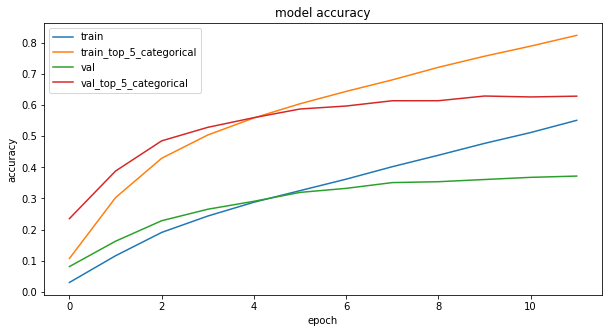

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['sparse_top_k_categorical_accuracy'])
plt.plot(history['val_accuracy'])
plt.plot(history['val_sparse_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'train_top_5_categorical', 'val', 'val_top_5_categorical'], loc='upper left')
plt.show()

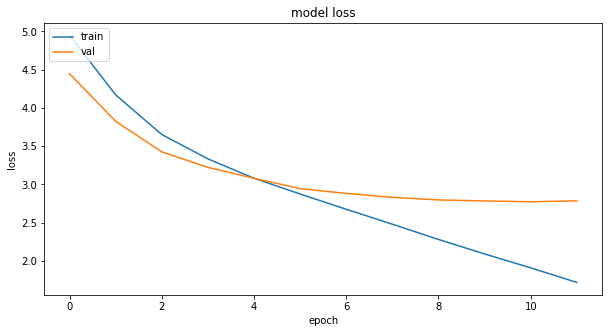

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Obtain the training, validation, and test metrics
training_results = model.evaluate(train_x, train_y, batch_size=100)
validation_results = model.evaluate(val_x, val_y, batch_size=100)
test_results = model.evaluate(test_x, test_y, batch_size=100)

# Create a dataframe that stores the loss, accuracy, and top-k categorical accuracy for each type of data set
column_names = ["loss", "accuracy", "top-5 categorical accuracy"]
df = pd.DataFrame(np.array([training_results, validation_results, test_results]), columns=column_names)
df["data"] = ["train", "val", "test"]
df = df[["data", *column_names]]
df

95/95 [==============================] - 7s 74ms/step - loss: 2.8532 - accuracy: 0.3634 - sparse_top_k_categorical_accuracy: 0.6256


data      loss  accuracy  top-5 categorical accuracy
0  train  0.906320  0.801329                    0.946974
1    val  2.785059  0.371895                    0.628632
2   test  2.853237  0.363368                    0.625579

## Evaluating and reporting the train, validation, and test performance, in terms of cross-entropy, classification accuracy, and top-5 classification accuracy.

Let us now evaluate the train, validation, and test performance, in terms of cross-entropy, classification accuracy, and top-5 classification accuracy. We will refer to the graphs and table above when evaluating the performance of the train, validation, and test set.

### **Train vs. Validation vs. Test.**

From the table above, we observe that evaluating the model with the training data results in a relatively high accuracy compared to the accuracy obtained on the validation and test data. The validation accuracy is slightly higher than the test accuracy, but the difference between these sets does not seem significant. We observe that the loss, accuracy, and top-5 categorical accuracy for the validation and test data are very similar, which is to be expected since the model has not been trained on this data.

While the table above provides useful information, it does not inform us about the learning curves of the model. With that thought in mind, we also plotted the accuracy and loss over the epochs for the training and validation data. If we take a closer look at the second graph, we observe that the validation loss starts to flatten after around four epochs, whereas the regular loss still decreases. This behavior is also reflected in the accuracy and validation accuracy in the first graph. Let us consider the first graph now. After four epochs, we observe the training accuracy is still increasing and that the validation accuracy is flattening. We observe the same trend for the top-5 classification accuracy on the training and validation set. These occurrences are signs of overfitting. In the next section, we will describe why we might be overfitting and how to tackle overfitting.

### **Interpreting overall loss, accuracy, and top-$k$ accuracy.**

In the table, we observe that the accuracy on all types of datasets is relatively low. One of the possible reasons for this could be due to us considering a total of 190 classes, i.e., we suspect that, on average, it is harder to predict 1 class from 190 classes than, for example, 1 class from 10 classes where we assume that the chance that two classes are similar is higher with the 190 classes than with the 10 classes since there are simply many more classes. Furthermore, it is possible for some classes to be similar, such as classes related to nature (e.g., forests and mountains with trees, which both contain (green) trees). We explore the latter reason more in a later section, in which we explore the qualitative differences between the different layers for the neural codes.

We observe a significant increase in accuracy when considering the top-5 categorical accuracy rather than the regular accuracy. This is pretty intuitive since we simply allow for more things to be correct; in our case, we have correctly predicted something if one of the 5 "nearest" predictions is correct rather than the single "nearest" prediction. This means that accuracy can only increase or stay the same. In our case, the top-5 categorical accuracy is significantly higher than the regular accuracy for all data sets.

We can do a few interesting observations when we compare the accuracy with the top-5 categorical accuracy. We observe that the accuracy on the training data went from 80.13% to 94.70% when considering the top-5 categorical accuracy, which is an increase of roughly 1.18. When we consider the validation and test data, we go from 37.19% to 36.34% to 62.86% and 62.56%, respectively. These are increases of roughly 1.69 and 1.72, respectively. These increases are significantly higher than the increase we had for the training set. We can argue this occurs because the accuracy on the training set was already significantly higher than the accuracy for the other sets, making it harder to perform this much better. We do, however, think it is interesting the accuracy increases this much on the validation and test data when we use the top-5 results rather than the top-1 result. This means that our model can make some 'good' predictions but that those 'good' predictions are not always the top-1 result. This makes it especially interesting and exciting to do a follow-up analysis where we use a few query images and plot their predictions (in sorted order) together with their classes to see if the predictions make sense (i.e., whether or not the argument we provided regarding certain classes looking similar holds).

## Two techniques which would likely improve the test accuracy

There are several techniques we could try that would likely improve the test accuracy. Before we discuss some techniques that are likely to improve the test accuracy, we first assume that we still want to use the Tiny Imagenet data set we use now rather than resorting to the Imagenet data set to obtain more data. We observed many other image classification tasks contain significantly more images than the Tiny Imagenet data set. While the Tiny Imagenet data set only contains 500 samples for each of the 200 classes, the CIFAR-10 data set (the data set used in practical 4a.0) contains more than 5,000 images for each of the ten classes (60,000 in total for all 10 classes). This brings us to our next point.

The relatively small number of training examples means that large models are prone to badly overfitting the data [2]. While we could argue about whether or not our model is "large", we can observe signs of overfitting in our model after around 4 epochs based on the graphs, table, and discussion in the previous text cells.

One way to tackle overfitting is by using data augmentation. Data augmentation, which we could implement with `keras.preprocessing.image.ImageDataGenerator `, is a method we could use to generate new images via image transformations that help fighting overfitting (assuming our data augmentation is appropriate for our use case and model). Using * proper* data augmentation, we might be able to make the model be able to generalize better on data it has never seen before (e.g., our test set). It is crucial to understand that not just any data augmentation will work and that this should be made very carefully. After all, we want to preserve the class of the image (i.e., we do not want to remove the part of the image that makes the image a particular class). We will not go in-depth regarding this choice since that seems to fall outside of the scope of this assignment, but we will briefly list a few possible options. Data augmentation that would make sense for our data set are taking horizontal translations and horizontal reflections of each image. Furthermore, we could apply some zooming in and out. The effect of these transformations is to increase generalization by making the model more robust [2]. Data augmentation also has some other neat advantages that can be found in [3], which we will not cover here.

Another way we can tackle overfitting while not having to create new artificial data is with model regularization (i.e., model level overfitting-avoiding techniques). We could, for example, try adding dropout after some convolutional layers, which can prevent overfitting due to a layer relying too much on a few of its inputs because these inputs are not always present during training (i.e., they are dropped at times due to the dropout) [4]. This way, the layer has to learn to use all of its inputs, which we suspect will improve generalization. Another option is to add L2-regularization to the layers, which is a commonly used regularization technique because it encourages smooth, diffuse weights and increases generalization of the model [2].

Outside of the techniques we already mentioned, we could also look into fine-tuning our model more; as of now, we follow the architecture used in [1] and the instructions of the assignment. The fine-tuning would consist of tuning hyperparameters (e.g., the learning rate). We could also try using different settings for the early-stopping. Furthermore, we could also take a good look at model ensembling. With model ensembling, we could generate multiple trained CNNs (with different hyperparameters and initializers) and combine them all to make an aggregated prediction. It is possible that one of the CNNs might perform well on certain classes, while another model might perform better on entirely different classes. The ensembled model might be able to do well on more of these classes than an individual model could. 


[2] http://cs231n.stanford.edu/reports/2015/pdfs/leonyao_final.pdf

[3] https://arxiv.org/pdf/1906.11052.pdf

[4] https://arxiv.org/pdf/1705.03419.pdf

# Image Retrieval

We can now using the trained model for image retrieval on the out-of-domain dataset ood_x. We are considering, in turn, single images from *ood_x* as query image, and the remaining 4,999 images as retrieval database.
The task of image retrieval (IR) is to find the *K* most similar images to the query image. In [1], similarity is defined as Euclidean distance between l2-normalised neural codes, where neural codes are simply the outputs of particular ConvNet layers.

For each of the *3* layers which were considered in [1], we perform the following steps:

1.  Image retrieval for the first *10* images from *ood_x*. Retrieve the *K=5* most similar images for each query. Show the query image and the retrieved images next to each other, and mark the retrieved images which have the same class (stored in *ood_y*) as the query image. See Fig. 2 and 3 in [1] for examples (your results do not need to look precisely like in the paper. E.g., you can use *imshow* and *subplot*, and simply use *print* for the labels). 

2.   Compute and report the *mean average precision* (mAP), by computing  the *average precision* (AP) for each image in *ood_x*, and taking the mean AP over all 5,000 images.

In [ ]:
model.summary()


def get_layer_functor(model, layer_name):
  inp = model.input 
  output =  model.get_layer(layer_name).output
  return K.function([inp], [output])


def eval_layer(x, layer_functor):
  return layer_functor(x)[0]


def eval_layer_batched(model, layer_name, x, batch_size):
  layer_functor = get_layer_functor(model, layer_name)
  idx = 0
  ret_vals = None
  while idx < x.shape[0]:
    if idx + batch_size > x.shape[0]:
      batch_x = x[idx:, ...]
    else:
      batch_x = x[idx:(idx+batch_size), ...]

    batch_vals = eval_layer(batch_x, layer_functor)
    if ret_vals is None:
      ret_vals = batch_vals
    else:
      ret_vals = np.concatenate((ret_vals, batch_vals), 0)

    idx += batch_size
  return ret_vals


def average_precision(sorted_class_vals, true_class):
  ind = sorted_class_vals == true_class
  num_positive = np.sum(ind)
  cum_ind = np.cumsum(ind).astype(np.float32)
  enum = np.array(range(1, len(ind)+1)).astype(np.float32)
  return np.sum(cum_ind * ind / enum) / num_positive

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 96)        4704      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 192)       460992    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 192)       0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       4

## Plotting 10 query images with next to 5 retrieved images in sorted order

max_pooling


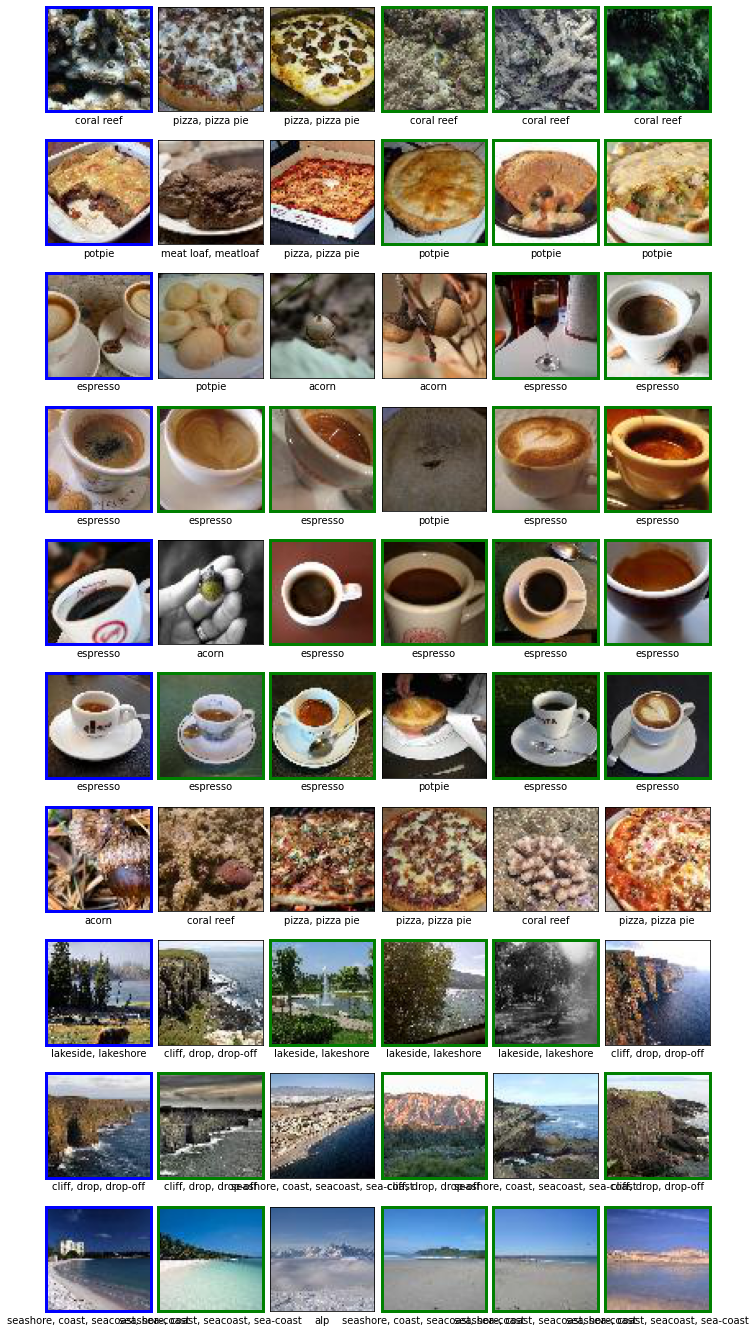

dense_1


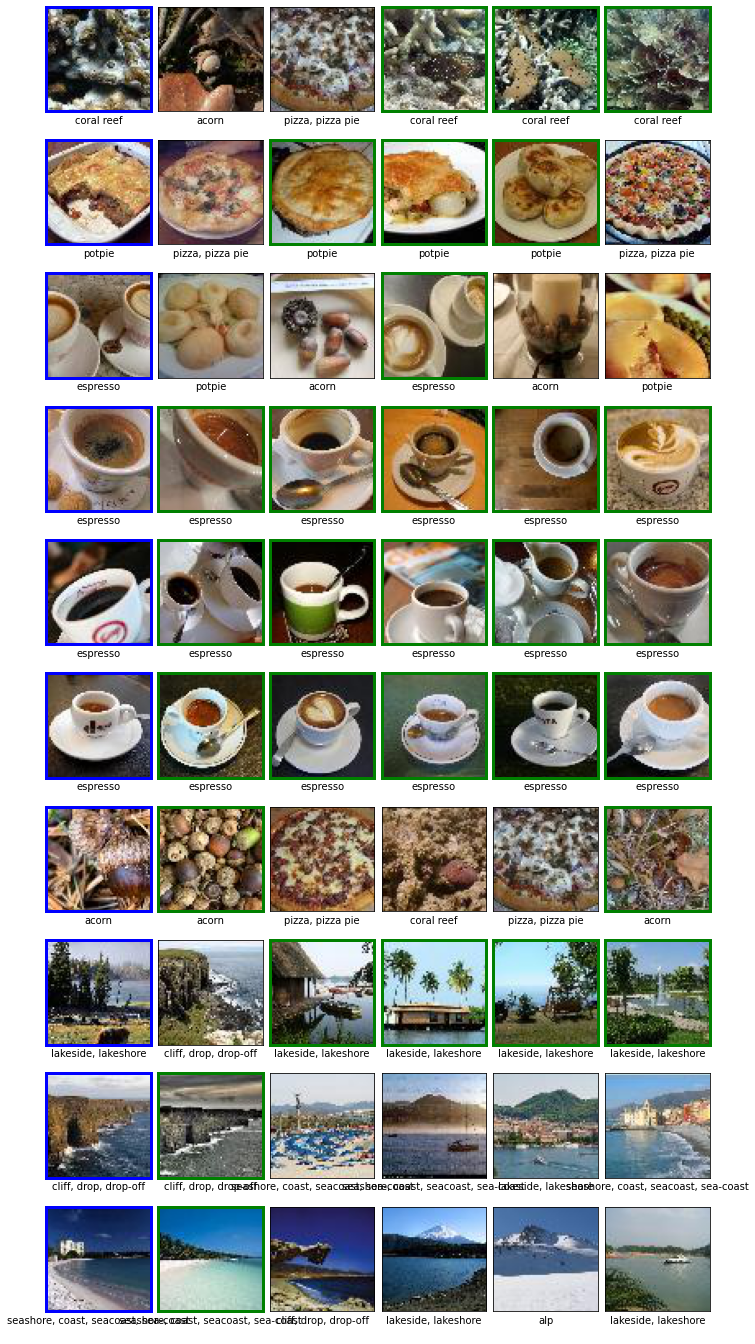

dense_2


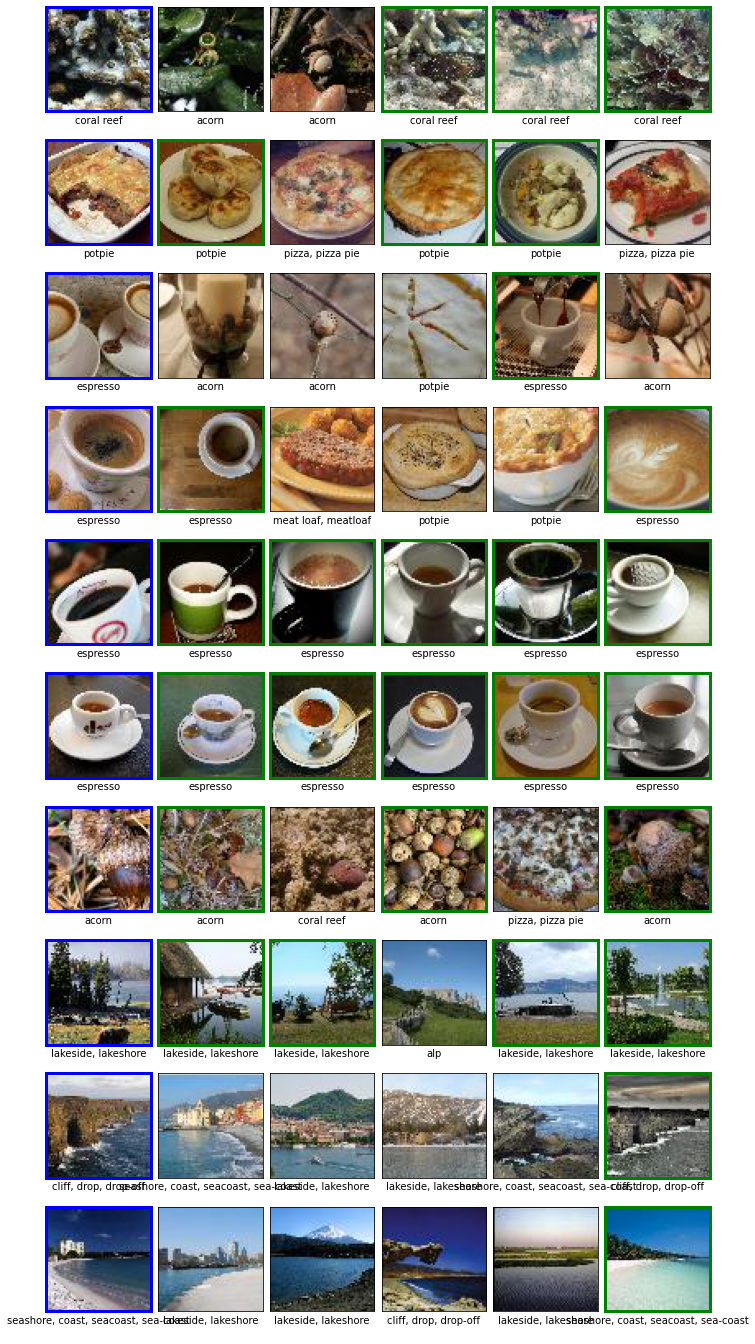

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import normalize
import itertools

# For the first 10 images in the ood set, find the respectively 5 closest images in the data set
n_rows = 10
n_nearest = 5

# Used for changing the imshow borders
positions = ["bottom", "top", "right", "left"]

# We denote with L5(I), L6(I), and L7(I) the activations (output) of the corresponding layer prior to the ReLU transform
layer_names = ["max_pooling", "dense_1", "dense_2"]

for layer_name in layer_names:
  print(layer_name)

  # Obtain neural codes for each image in the ood data
  neural_codes = eval_layer_batched(model, layer_name, ood_x, 100)
  
  # We need to reshape the max pooling layer since its output has different dimensions than the output of the dense layers
  if layer_name == layer_names[0]:
    neural_codes = neural_codes.reshape(-1, 256*8*8)

  # Normalize the codes to have unit length; we exploat the relation between inner products and Euclidean distances later
  neural_codes = normalize(neural_codes, norm='l2')

  # Test if we have correctly converted our neural codes to unit length
  # print(np.linalg.norm(neural_codes[1]))  # should equal 1

  # Store the distance per row where each row represents a different query image indicated with neural_codes[i]
  distances_per_row = []
  for i in range(n_rows):
    distances_per_row.append(np.sqrt([(np.dot(neural_codes[i] - entry, neural_codes[i] - entry)) for entry in neural_codes]))

  # Store the top `n_nearest` images per row using argsort
  top_nearest_per_row = []
  for row in distances_per_row:
    top_nearest_per_row.append(np.array(row).argsort()[:n_nearest+1])

  # Store a list with whether or not a "prediction" is correct
  correct_predictions = []

  # Iterate over each row
  for indices in top_nearest_per_row:
    # Mark all the ground truth images as false since these are the query images
    correct_predictions.append('truth')
    # Get the class of the ground truth label
    ground_truth = class_dict[ood_y[indices[0]]]
    
    # Iterate over all images we "predict" and check if their class equals the class of the ground truth
    for index in indices[1:n_nearest+1]:
      predicted = class_dict[ood_y[index]]
      correct_predictions.append('correct') if predicted == ground_truth else correct_predictions.append('incorrect')

  images_to_plot = list(itertools.chain(*top_nearest_per_row))

  # Plotting the images
  fig = plt.figure(figsize=(24, 24))
  grid = ImageGrid(fig, 111,
                  nrows_ncols=(n_rows, 6),
                  axes_pad=(0.1, 0.4),
                  label_mode='all')

  # Plot the query image next to the 5 retrieved images (sorted from most to least similar) 
  # and mark the images which have the same class as the query image (see Fig. 2 and 3 in [1])
  for ax, img, correct_prediction in zip(grid, images_to_plot, correct_predictions):
      # ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Give the query and correct images a thicker width and height
      if correct_prediction != 'incorrect':
        for position in positions: ax.spines[position].set_linewidth(3)
        # Color the "correct" images green and the "truth" images blue
        if correct_prediction == 'correct':
          for position in positions: ax.spines[position].set_color('green')
        elif correct_prediction == 'truth':
          for position in positions: ax.spines[position].set_color('blue')

      # Plot the image
      ax.imshow(ood_x[img])
      # Add the class as a label
      ax.set_xlabel(class_dict[ood_y[img]])
      # Remove the x-axis ticks and tick labels
      ax.set_xticks([])
      ax.set_xticklabels([])

  plt.show()

## The qualitative differences between the different layers for neural codes?

Before taking a closer look at the qualitative differences between the different layers for neural codes, note that information and motivation about the code can be found as comments in the code. Furthermore, note that we gave the query images a blue border to differentiate between the query images and the sorted retrieved images more easily. All correct retrieved images have been given a green border. Moreover, the class of all images has been annotated below the image. This helps us during our discussion.

#### **Comparing layers based on correct image retrievals per query image.**
To give a clear overview of the three layers' qualitative performances, we have created a table with the results of the query images and the retrieved images, highlighting the number of correct predictions in the top-5 images on a per-layer basis. Each row in the table corresponds to a single query image, and the three right-most columns contain the number of correctly retrieved images (out of 5). We have also included another table, in which the query images are aggregated by their category, which makes it possible for us to discuss the performance of embeddings from a certain layer on a per-category basis. From here on, we denote the max-pooling layer, first dense layer, and second dense layer as layer 5, layer 6, and layer 7, respectively.

| Query Image | Total correct (Layer 5)  | Total correct (Layer 6) | Total correct (Layer 7) |
|------|------|------|------|
|  1 (coral reef)  | 3 | 3 | 3 |
|  2 (potpie)  | 3 | 3 | 3 |
|  3 (espresso)  | 2 | 1 | 1 |
|  4 (espresso)  | 4 | 5 | 2 |
|  5 (espresso)  | 4 | 5 | 5 |
|  6 (espresso)  | 4 | 5 | 5 |
|  7 (acorn)  | 0 | 2 | 3 |
|  8 (lakeside, lakeshore)  | 3 | 4 | 4 |
|  9 (cliff, drop, drop-off)  | 3 | 1 | 1 |
|  10 (seashore, coast, sea-coast)  | 4 | 1 | 1 |
| Total | 30 | 30 | 28 |

From the table above, we can see that layer 6 and layer 5 have retrieved the most images correctly with a total of 30 images (out of 50). Layer 7 retrieved a total of 28 images (out of 50) correctly. Based on our very limited number of samples, these results seem to suggest that layers 5 and 6 perform the best on this task. However, it could be the case that layer 7 outperforms these layers concerning the total number of correct predictions in the top-5 nearest predictions when we consider all samples instead of only the first 10. This is something we will explore in the next section, where we look at the mAP values of each layer based on **all** images in the OOD data set.

#### **Comparing layers based on correct image retrievals, aggregated by classes.**
| Image Class | Total per Class | Total correct (Layer 5)  | Total correct (Layer 6) | Total correct (Layer 7) |
|------|------|------|------|------|
|  coral reef | 5 | 3 | 3 | 3 |
|  potpie | 5 | 3 | 3 | 3 |
|  espresso | 20  | 14 | 16 | 13 |
|  acorn | 5 | 0 | 2 | 3 |
|  lakeside, lakeshore | 5 | 3 | 4 | 4 |
|  cliff, drop, drop-off | 5 | 3 | 1 | 1 |
|  seashore, coast, sea-coast  | 5 | 4 | 1 | 1 |
| Total | 50 | 30 | 30 | 28 |

From the table above, we can observe how well each layer did on each class to see whether, e.g., one layer performed well on class A but poorly on class B, whereas it is the opposite for another class.

We can immediately see that layers 5 and 6, which are also the layers with the most correctly retrieved images in the previous paragraph, perform well on all classes except for "acorn". Layer 5 had no correct predictions, and layer 6 had 2 correct predictions out of 5. We observe that layer 6 performs better on "cliff" and "seashore" than layer 6, but that layer 6 performs better than layer 5 on "acorn". From this, we would argue that, although layer 5 has better performance when we consider "cliff" and "seashore", when we would need to retrieve 100 images of acorns, opting for layer 6 would not be a bad choice (i.e., not as bad as using layer 5).

#### **Comparing image classes.**
We also see that there are classes that are much easier to retrieve images from. When we look at, e.g., "espresso", we see that all images are quite clearly an espresso. The reason for this is that the cup of espresso does not have a complex shape and can more easily be captured in a small image since the object itself is much smaller, which is not the case with many other classes in the OOD dataset (e.g., ones related to nature that fill the whole image).

On the other hand, some classes are much more difficult to correctly retrieve images from for layers 6 and 7. For example, the classes related to nature or landscapes are difficult to predict correctly. Examples are the classes "lakeside, lakeshore", "seashore, coast, sea-coast", and "cliff, drop, drop-off". The reason for this is that these pictures are quite complex, and differences between these classes are much more subtle and are thus harder to capture in a 64 x 64 x 3 image, which in turn makes it harder for our model to extract important features from to make good image retrievals. 

Lastly, "acorn" is a class that all layers struggled with; layers 5, 6, and 7 correctly retrieved 0, 2, and 3 images, respectively. We believe that this low number of correct retrievals stems from most images of the acorn being very zoomed-in images with different backgrounds and angles, which makes it difficult for the layers to extract important features from. We observe that each acorn image plotted above has a different background and an acorn of a different color, at vastly different zoom levels.

## Computing and reporting the mean average precision (mAP) over the whole ood set, for each of the 3 layers.

In [ ]:
def compute_mAPs(neural_codes, class_dict):
  # Store the distance per row where each row represents a different query image indicated with neural_codes[i]
  distances_per_row = []
  
  # Iterate over all images (5000)
  for i in range(len(neural_codes)):
    distances_per_row.append(np.sqrt([(np.dot(neural_codes[i] - entry, neural_codes[i] - entry)) for entry in neural_codes]))

  # Store the images per row using argsort
  top_nearest_per_row = []
  for row in distances_per_row:
    top_nearest_per_row.append(np.array(row).argsort())

  # Store the precision for each image
  precision = []

  # Iterate over each row (5000 in total)
  for indices in top_nearest_per_row:
    # Get the class of the ground truth label
    ground_truth = class_dict[ood_y[indices[0]]]
    
    # Store all classes
    classes = []
    
    # Iterate over all images we want to "predict"
    for index in indices[1:]:
      # Append the class labels
      classes.append(class_dict[ood_y[index]])

    # Obtain the average precision based on a custom function
    avg_precision = average_precision(np.array(classes), ground_truth)
    precision.append(avg_precision)

  # Compute the mean average precision (mAP)
  return np.mean(precision)


# Iterate over all layers
for layer_name in layer_names:
  # Obtain the neural codes
  neural_codes = eval_layer_batched(model, layer_name, ood_x, 100)

  # Normalize the codes to have unit length
  if layer_name == layer_names[0]:
      neural_codes = neural_codes.reshape(-1, 256*8*8)

  neural_codes = normalize(neural_codes, norm='l2')
  print(f"{layer_name} : {round(compute_mAPs(neural_codes, class_dict), 4)}")

max_pooling : 0.284
dense_1 : 0.3204
dense_2 : 0.3485


## How do the observed mAP values compare to the observations made by Babenko et al. [1]?

The observed mAP values (rounded at four decimals) for the different layers considering all samples in the OOD dataset are as follows:
- 0.2840 for layer 5 (`max_pooling`).
- 0.3204 for layer 6 (`dense_1` layer).
- 0.3485 for layer 7 (`dense_2` layer).

We observe that our results are somewhat similar to the results obtained by Babenko et al. [1] in that the `max_pooling` layer attains the lowest mAP. For Babenko et al. [1], the first `dense` layer performed a bit better than the second `dense` layer on most of the datasets even after retraining on other datasets. There are some exceptions where the mAP value of the first and second `dense` layers differed a bit more, but the overall order of best performing layers based on the mAP is preserved across datasets. This order, starting with the highest mAP and ending with the lowest mAP is: 1) the first `dense` layer, 2) the second `dense` layer, 3) the `max_pooling` layer. This order is not precisely what we observe when we consider the order of our results. In our case, the second dense layer attains a higher mAP than the first dense layer. We also observe that our mAP values are slightly lower than the mAP values obtained by Babenko et al. [1] on the Oxford dataset. 

There are several possible reasons for the observed difference between our mAP values and the ones obtained by Babenko et al. [1], including the difference in the ranking of the layers based on the mAP values. The first possible reason is that Babenko et al. did not use the same dataset as we did, and thus their model considered different images to train on and retrieve. For training their model, Babenko et al. initially used the ILSVRC (2010) dataset, which consists of 200,000 photographs and 1,000 classes [5]. To put things in perspective, our dataset, the Tiny ImageNet, consists of 100,000 images and 200 classes. Our dataset had fewer classes, but more images per class than the dataset of Babenko et al. This showcases that the two datasets are different in size. It is also very possible that Tiny ImageNet contains images that are generally easier or harder to classify than images from the ILSVRC dataset. The fact that different datasets were used to train the model on remains.
Another possible reason is that our model architecture slightly deviates from the architecture proposed by Babenko et al. [1]. As mentioned in our "make and train model" section, our architecture has been simplified. For example, our last two hidden layers have twice as few nodes (2048 instead of 4096), which results in fewer parameters to train.

As a side note: in the previous question, where we looked at the qualitative differences between the different layers for neural codes, we observed that the `max_pooling` and first `dense` layer performed the best with respect to the total number of correct predictions based on the top 5 nearest predictions. Based on the mAP values obtained for the different layers in this part, we could argue that our second `dense` layer performs better than the other layers when we consider all samples in the OOD set rather than the first 10 samples. Hence, we can argue that we should not conclude that the `max_pooling` and first `dense` layer performs better than the other layers merely because the total number of correct predictions was higher in the previous question. Clearly, these 10 samples were not representative of the whole OOD set.

[5] http://www.image-net.org/challenges/LSVRC/2010/